In [29]:
import pandas as pd
import numpy as np
import random
import sys
from scipy import interpolate
import cmath
import matplotlib.pyplot as plt
import matplotlib.font_manager
import statistics as std

In [3]:
g = 0.05
s = 0.04
bigy=(3-s)**0.5
labelfontsize = 30

###Circuit Parameters###
U = .1
# Cknob = 0.125
Cknob = 0.0028
cable = 1.5
eta = 0.0104
phi = 6.1319
Cstray = 10**(-15)

k_range = 5000
circ_constants = (3*10**(-8),0.35,619,50,10,0.0343,4.752*10**(-9),50,1.027*10**(-10),2.542*10**(-7),0,0,0,0)
circ_params = (U,Cknob,cable,eta,phi,Cstray)
function_input = 32000000
# function_input = 213000000
scan_s = .25
ranger = 0
# ---- Data Files ---- #
Backgmd = np.loadtxt(r'Q_Meter_Data/Backgmd.dat', unpack = True)
Backreal = np.loadtxt(r'Q_Meter_Data/Backreal.dat', unpack = True)
Current = np.loadtxt(r'Q_Meter_Data/New_Current.csv', unpack = True)
# Deuteron_Dat = np.loadtxt(r'C:\Users\Devin\Desktop\Spin Physics Work\ANN-NMR-main\Qmeter_Simulation\qmeter_simulation-master\data\DEUTERON.dat', unpack = True)
# Deuteron_Deriv = np.loadtxt(r'C:\Users\Devin\Desktop\Spin Physics Work\ANN-NMR-main\Qmeter_Simulation\qmeter_simulation-master\data\DDEUTERON.dat', unpack = True)
# Deuteron_Dat = np.loadtxt(r'C:\Users\Devin\Desktop\Spin Physics Work\ANN-NMR-main\Qmeter_Simulation\qmeter_simulation-master\data\PROTON.dat', unpack = True)
# Deuteron_Deriv = np.loadtxt(r'C:\Users\Devin\Desktop\Spin Physics Work\ANN-NMR-main\Qmeter_Simulation\qmeter_simulation-master\data\DPROTON.dat', unpack = True)
Deuteron_Empty = np.zeros(500)

In [4]:
def LabviewCalculateXArray(f_input, scansize, rangesize):
    
    #---------------------preamble----------------
    
    pi = np.pi
    im_unit = complex(0,1)

    #----------------------main------------------
    
    
    

    #Derived quantities
    w_res = 2*pi*f_input
    f_small = f_input/(1e6)
    w_low = 2 * pi * (f_small - scansize) * (1e6)
    w_high = 2 * pi * (f_small + scansize) * (1e6)
    delta_w = 2 * pi * 500 * ((1e3)/500)

    
    #Variables for creating splines
    k_ints = range(0,500)
    k = np.array(k_ints,float)
    x = (k*delta_w)+(w_low)
    
    larger_k = range(0,k_range)
    larger_x = np.array(larger_k, float)
    w_range = w_high - w_low
    larger_range = (delta_w*larger_x)+(w_low-5*w_range)
    larger_range /= (2 * pi)*(1e6)
    
    x /= (2*pi)*(1e6)
    return_val = x
    if (rangesize == 1):
        return_val = larger_range
    return return_val

def getArrayFromFunc(func,inputs):
    output = []
    for input in inputs:
        output.append((func(input)).real)
    return output

def LabviewCalculateYArray(circ_consts, params, f_input, scansize, main_sig, deriv_sig, backgmd_sig, backreal_sig, current_sig, rangesize):
    
    #---------------------preamble----------------
    
    pi = np.pi
    im_unit = complex(0,1)
    sign = 1
    
    #----------------------main------------------

    L0 = circ_consts[0]
    Rcoil = circ_consts[1]
    R = circ_consts[2]
    R1 = circ_consts[3]
    r = circ_consts[4]
    alpha = circ_consts[5]
    beta1 = circ_consts[6]
    Z_cable = circ_consts[7]
    D = circ_consts[8]
    M = circ_consts[9]
    delta_C = circ_consts[10]
    delta_phi = circ_consts[11]
    delta_phase = circ_consts[12]
    delta_l = circ_consts[13]
    
    
    f = f_input
    
    U = params[0]
    knob = params[1]
    trim = params[2]
    eta = params[3]
    phi_const = params[4]
    Cstray = params[5]
    
    I = U*1000/R #Ideal constant current, mA

    #Derived quantities
    w_res = 2*pi*f
    w_low = 2 * pi * (213 - scansize) * (1e6)
    w_high = 2 * pi * (213 + scansize) * (1e6)
    delta_w = 2 * pi * 500 * ((1e3)/500)
    
    #Functions
    def slope():
        return delta_C / (0.25 * 2 * pi * 1e6)

    def slope_phi():
        return delta_phi / (0.25 * 2 * pi * 1e6)

    def Ctrim(w):
        return slope()*(w - w_res)

    def Cmain():
        return 20*(1e-12)*knob

    def C(w):
        return Cmain() + Ctrim(w)*(1e-12)

    def Cpf():
        return C(w_res)*(1e12)
    
    
    #--------------------Cable characteristics-------------


    #Derived quantities
    S = 2*Z_cable*alpha

    #Functions

    def Z0(w):
        return cmath.sqrt( (S + w*M*im_unit) / (w*D*im_unit))

    def beta(w):
        return beta1*w

    def gamma(w):
        return complex(alpha,beta(w))

    def ZC(w):
        if  w != 0 and C(w) != 0:
            return 1/(im_unit*w*C(w))
        return 1
  
    #More derived quantities
    vel = 1/beta(1)

    #More functions
    def lam(w):
        return vel/f
    
    #Even more derived quantities
    l_const = trim*lam(w_res)

    #Even more functions
    def l(w):
        return l_const + delta_l
        
 
        
    
    #Variables for creating splines
    k_ints = range(0,500)
    k = np.array(k_ints,float)
    x = (k*delta_w)+(w_low)
    Icoil_TE = 0.11133
    
    butxi = []
    butxii = []
    vback = []
    vreal = []    
    Icoil = []
    
    for item in deriv_sig:
        butxi.append(item)
    for item in main_sig:
        butxii.append(item)
    for item in backgmd_sig:
        vback.append(item)
    for item in backreal_sig:
        vreal.append(item)
    for item in current_sig:
        Icoil.append(item)
    
    x1 = interpolate.interp1d(x,butxi,fill_value=0.0,bounds_error=False)
    x2 = interpolate.interp1d(x,butxii,fill_value=0.0,bounds_error=False)
    # b = interpolate.interp1d(x,vback,fill_value="extrapolate",kind="quadratic",bounds_error=False)
    # rb = interpolate.interp1d(x,vreal,fill_value="extrapolate",kind="quadratic",bounds_error=False)
    ic = interpolate.interp1d(x,Icoil,fill_value="extrapolate",kind="linear",bounds_error=False)
    
    def chi(w):
        return complex(x1(w),-1*x2(w))

    
    
    def pt(w):
        return ic(w)/Icoil_TE

    def L(w):
        return L0*(1+(sign*4*pi*eta*pt(w)*chi(w)))

    def real_L(w):
        return L(w).real

    def imag_L(w):
        return L(w).imag

    def ZLpure(w):
        return im_unit*w*L(w) + Rcoil

    def Zstray(w):
        if w != 0 and Cstray !=0:
            return 1/(im_unit*w*Cstray)
        return 1

    def ZL(w):
        return ZLpure(w)*Zstray(w)/(ZLpure(w)+Zstray(w))

    def ZT(w):
        return Z0(w)*(ZL(w) + Z0(w)*np.tanh(gamma(w)*l(w)))/(Z0(w) + ZL(w)*np.tanh(gamma(w)*l(w)))


    def Zleg1(w):
        return r + ZC(w) + ZT(w)

    def Ztotal(w):
        return R1 / (1 + (R1 / Zleg1(w)) )

    #Adding parabolic term

    xp1 = w_low
    xp2 = w_res
    xp3 = w_high
    yp1 = 0
    yp2 = delta_phase
    yp3 = 0

    alpha_1 = yp1-yp2
    alpha_2 = yp1-yp3
    beta_1 = (xp1*xp1) - (xp2*xp2)
    beta_2 = (xp1*xp1) - (xp3*xp3)
    gamma_1 = xp1-xp2
    gamma_2 = xp1-xp3
    temp=(beta_1*(gamma_1/gamma_2) - beta_2)
    a= (gamma_2 *(alpha_1/gamma_1) - alpha_2)/temp
    bb = (alpha_2 - a*beta_2)/gamma_2
    c = yp1 - a*xp1*xp1 - bb*xp1

    def parfaze(w):
        return a*w*w + bb*w + c

    def phi_trim(w):
        return slope_phi()*(w-w_res) + parfaze(w)

    def phi(w):
        return phi_trim(w) + phi_const

    def V_out(w):
        return -1*(I*Ztotal(w)*np.exp(im_unit*phi(w)*pi/180))

    
    larger_k = range(0,k_range)
    larger_x = np.array(larger_k, float)
    w_range = w_high - w_low
    larger_range = (delta_w*larger_x)+(w_low-5*w_range)
    
    out_y = getArrayFromFunc(V_out,x)
    if (rangesize == 1):
        out_y = getArrayFromFunc(V_out,larger_range)
    return out_y

    
# baseline = LabviewCalculateYArray(circ_constants, circ_params, function_input, scan_s, Deuteron_Dat, Deuteron_Deriv, Backgmd, Backreal, Current, ranger)
    

def cosal(x,eps):
    return (1-eps*x-s)/bigxsquare(x,eps)


def c(x):
    return ((g**2+(1-x-s)**2)**0.5)**0.5


def bigxsquare(x,eps):
    return (g**2+(1-eps*x-s)**2)**0.5


def mult_term(x,eps):
    return float(1)/(2*np.pi*np.sqrt(bigxsquare(x,eps)))


def cosaltwo(x,eps):
    return ((1+cosal(x,eps))/2)**0.5


def sinaltwo(x,eps):
    return ((1-cosal(x,eps))/2)**0.5


def termone(x,eps):
    return np.pi/2+np.arctan((bigy**2-bigxsquare(x,eps))/((2*bigy*(bigxsquare(x,eps))**0.5)*sinaltwo(x,eps)))


def termtwo(x,eps):
    return np.log((bigy**2+bigxsquare(x,eps)+2*bigy*(bigxsquare(x,eps)**0.5)*cosaltwo(x,eps))/(bigy**2+bigxsquare(x,eps)-2*bigy*(bigxsquare(x,eps)**0.5)*cosaltwo(x,eps)))

def icurve(x,eps):
    return mult_term(x,eps)*(2*cosaltwo(x,eps)*termone(x,eps)+sinaltwo(x,eps)*termtwo(x,eps))


In [5]:
xvals = np.linspace(-6,6,500)
yvals = icurve(xvals,1)/10
yvals2 = icurve(-xvals,1)/10

center = 250
length = range(500)
norm_array = []
for x in length:
    norm_array = np.append(norm_array,(x - center)*(12/500))  
Iplus = icurve(norm_array,1)
Iminus = icurve(norm_array,-1)
ratio = Iminus/Iplus

SNR_level = 2.5

6.459649330992079e-07


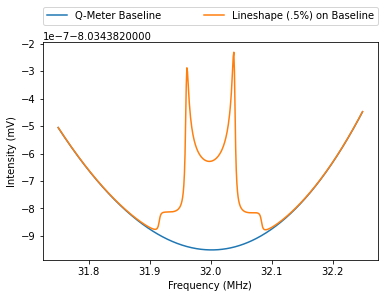

In [49]:
x_arr = np.linspace(31.5,32.5,500)
P = .05
r = (np.sqrt(4-3*P**(2))+P)/(2-2*P)
Iminus = icurve(norm_array,-1)
array = r*Iminus
array_flipped = np.flip(array)
element_1 = array_flipped+Iminus
sum_array = np.sum(array_flipped)*(12/500)
element_2 = 1/sum_array
element_3 = P
signal = element_1*element_2*element_3
result = signal 
lineshape = LabviewCalculateYArray(circ_constants, circ_params, function_input, scan_s, result, result, Backgmd, Backreal,Current, ranger)
lineshape_clean = LabviewCalculateYArray(circ_constants, circ_params, function_input, scan_s, Deuteron_Empty, Deuteron_Empty, Backgmd, Backreal,Current, ranger)
offset = [x - max(lineshape) for x in lineshape]
offset_wo_Q = [x - y for x,y in zip(lineshape,lineshape_clean)]
noisey = max(list(map(abs, offset)))/SNR_level
fluc = noisey*.01
print(max(list(map(abs, offset))))
noise = np.random.normal(noisey,fluc,500)
# sig = offset + noise
sig = lineshape
x_sig = max(list(map(abs, offset)))
y_sig = max(list(map(abs,noise)))
Lineshape_X = LabviewCalculateXArray(function_input, scan_s, ranger)
SNR = (x_sig/y_sig)
plt.rcParams["font.family"] = "Times New Roman"
plt.plot(Lineshape_X,lineshape_clean,label = 'Q-Meter Baseline')
plt.plot(Lineshape_X,lineshape, label = 'Lineshape (.5%) on Baseline')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Intensity (mV)')
plt.legend(bbox_to_anchor=(0, 1.08, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)
# plt.xlim([31.85,32.15])
# plt.title("P_true:" + str(np.round(P*100,6)) + "\n SNR:" + str(SNR))
plt.savefig('Baseline.pdf')